Import neccessary packages.

In [1]:
import os
import scvelo as scv
import scanpy as sc
import cellrank as cr
import warnings
warnings.filterwarnings('ignore')

Read in the loom output files from velocyto and format them so that gene names are unique and cell barcodes match those in the GEX data. Join the loom files into one dataset to work with.

In [2]:
################
# Format loom #
################

# get relative paths to all loom files from velocyto results folder
os.chdir('/home/ikernin/projects/asthma/cellranger_output')
path_dict = {}
for filename in os.listdir():
    if os.path.isdir(filename):
        if filename != "cache":  # cache folder created later on
            for loom in os.listdir(filename):
                path_dict[filename] = os.path.join(filename, loom)

# read in loom files and format barcodes and var names
loom_dict = {}
for idx, sample in enumerate(path_dict.keys()):
    print(f"Current sample: {sample} ({idx + 1}/{len(path_dict)})...")
    # read in loom file for sample
    temp_loom = scv.read(path_dict[sample], cache=True)
    # format obs and var names
    temp_loom.obs.index.name = None
    temp_loom_barcodes = ['-'.join([sample, x.split(":")[1][:-1]]) for x in temp_loom.obs_names.values]
    temp_loom.obs_names = temp_loom_barcodes
    temp_loom.var_names_make_unique()
    # store formatted loom
    loom_dict[sample] = temp_loom

# join loom files into one
samples = list(loom_dict.keys())
loom_df = loom_dict[samples[0]]
for s in samples[1:]:
    loom_df = loom_df.concatenate(loom_dict[s], index_unique=None)

Current sample: 500015_ANA_Pre (1/21)...
Current sample: 500008_ANA_Pre (2/21)...
Current sample: 500021_AA_Ag (3/21)...
Current sample: 500030_AA_Dil (4/21)...
Current sample: 500021_AA_Dil (5/21)...
Current sample: 500032_AA_Ag (6/21)...
Current sample: 500008_ANA_Ag (7/21)...
Current sample: 500012_ANA_Pre (8/21)...
Current sample: 500012_ANA_Dil (9/21)...
Current sample: 500030_AA_Pre (10/21)...
Current sample: 500035_AA_Pre (11/21)...
Current sample: 500015_ANA_Ag (12/21)...
Current sample: 500032_AA_Pre (13/21)...
Current sample: 500024_ANA_Ag (14/21)...
Current sample: 500012_ANA_Ag (15/21)...
Current sample: 500021_AA_Pre (16/21)...
Current sample: 500024_ANA_Pre (17/21)...
Current sample: 500030_AA_Ag (18/21)...
Current sample: 500035_AA_Ag (19/21)...
Current sample: 500024_ANA_Dil (20/21)...
Current sample: 500008_ANA_Dil (21/21)...


Prepare the data for velocity analysis by subsetting the GEX data to the clusters of interest and merging this dataset with the spliced/unspliced transcript data. Further pre-process by normalizing the transcript data, computing a KNN graph, and recovering velocity information.

In [3]:
###############
# Pre-process #
###############

# read in gex data
os.chdir('/projects/medoff/data')
myeloid_df = sc.read_h5ad('mnp_harmonized.h5ad')

# subset for given clusters
select_clusters = ['1', '2', '3', '8', '9']
filtered_df = myeloid_df[myeloid_df.obs['new_clusters'].isin(select_clusters)].copy()

# merge loom and gex df
velo_df = scv.utils.merge(filtered_df, loom_df)

# scvelo pre-processing steps
scv.pp.filter_and_normalize(velo_df)  # normalize spliced and un-spliced count data (leaves X alone)
n_pc = velo_df.obsm['X_pca'].shape[1]  # get number of PCs from pre-computed pca
sc.pp.neighbors(velo_df, n_pcs=n_pc, n_neighbors=30)  # use scanpy KNN for formatting
scv.pp.moments(velo_df, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(velo_df, n_jobs=10) 

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 10/96 cores)


  0%|          | 0/2606 [00:00<?, ?gene/s]

    finished (0:01:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Compute a velocity graph along with the confidence of velocities. Plot velocity streamlines and confidences on UMAP embeddings.

computing velocities
    finished (0:00:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/96 cores)


  0%|          | 0/3908 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_myeloid_subset_velocity.svg


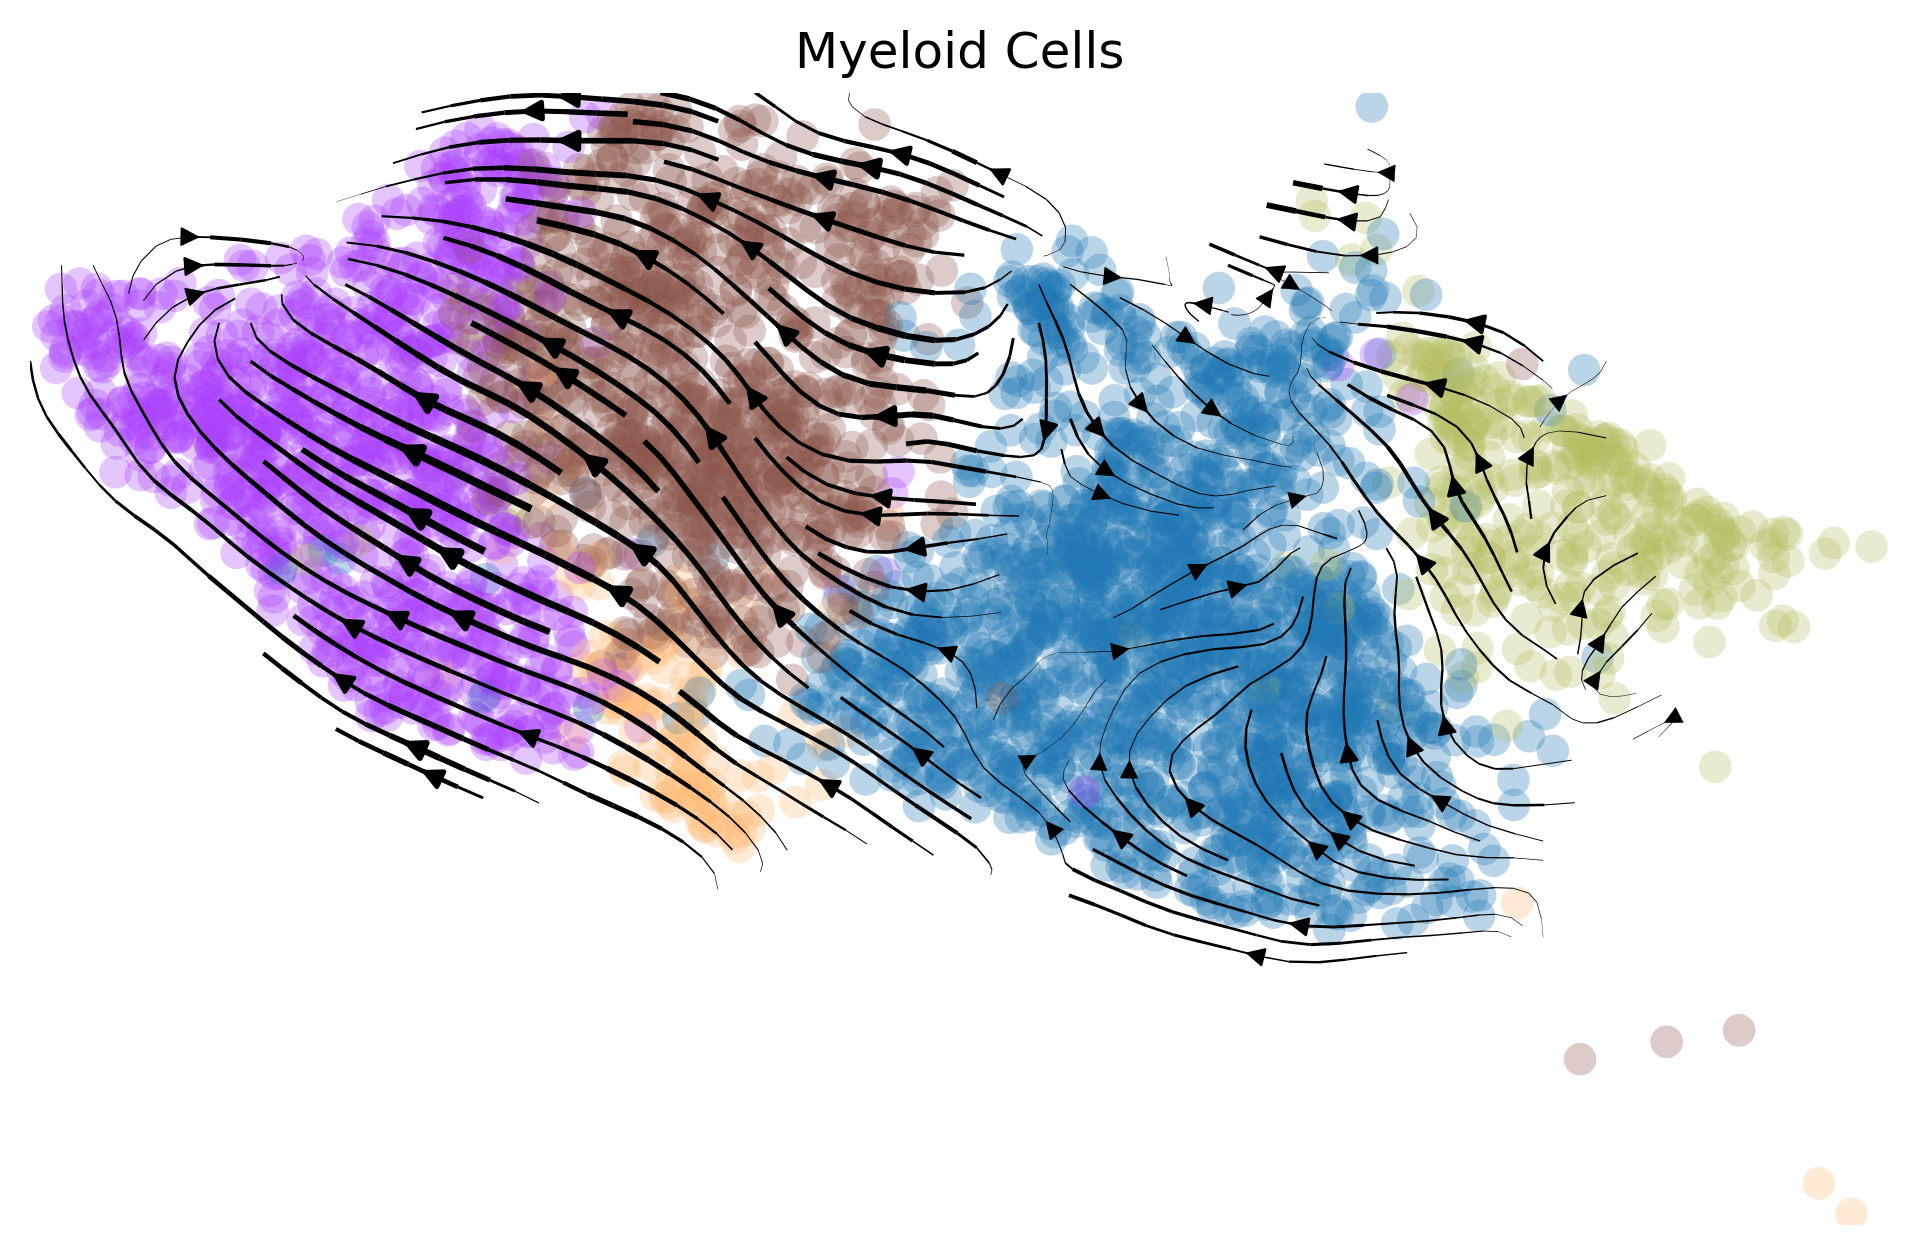

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
saving figure to file ./figures/scvelo_myeloid_subset_coherence.pdf


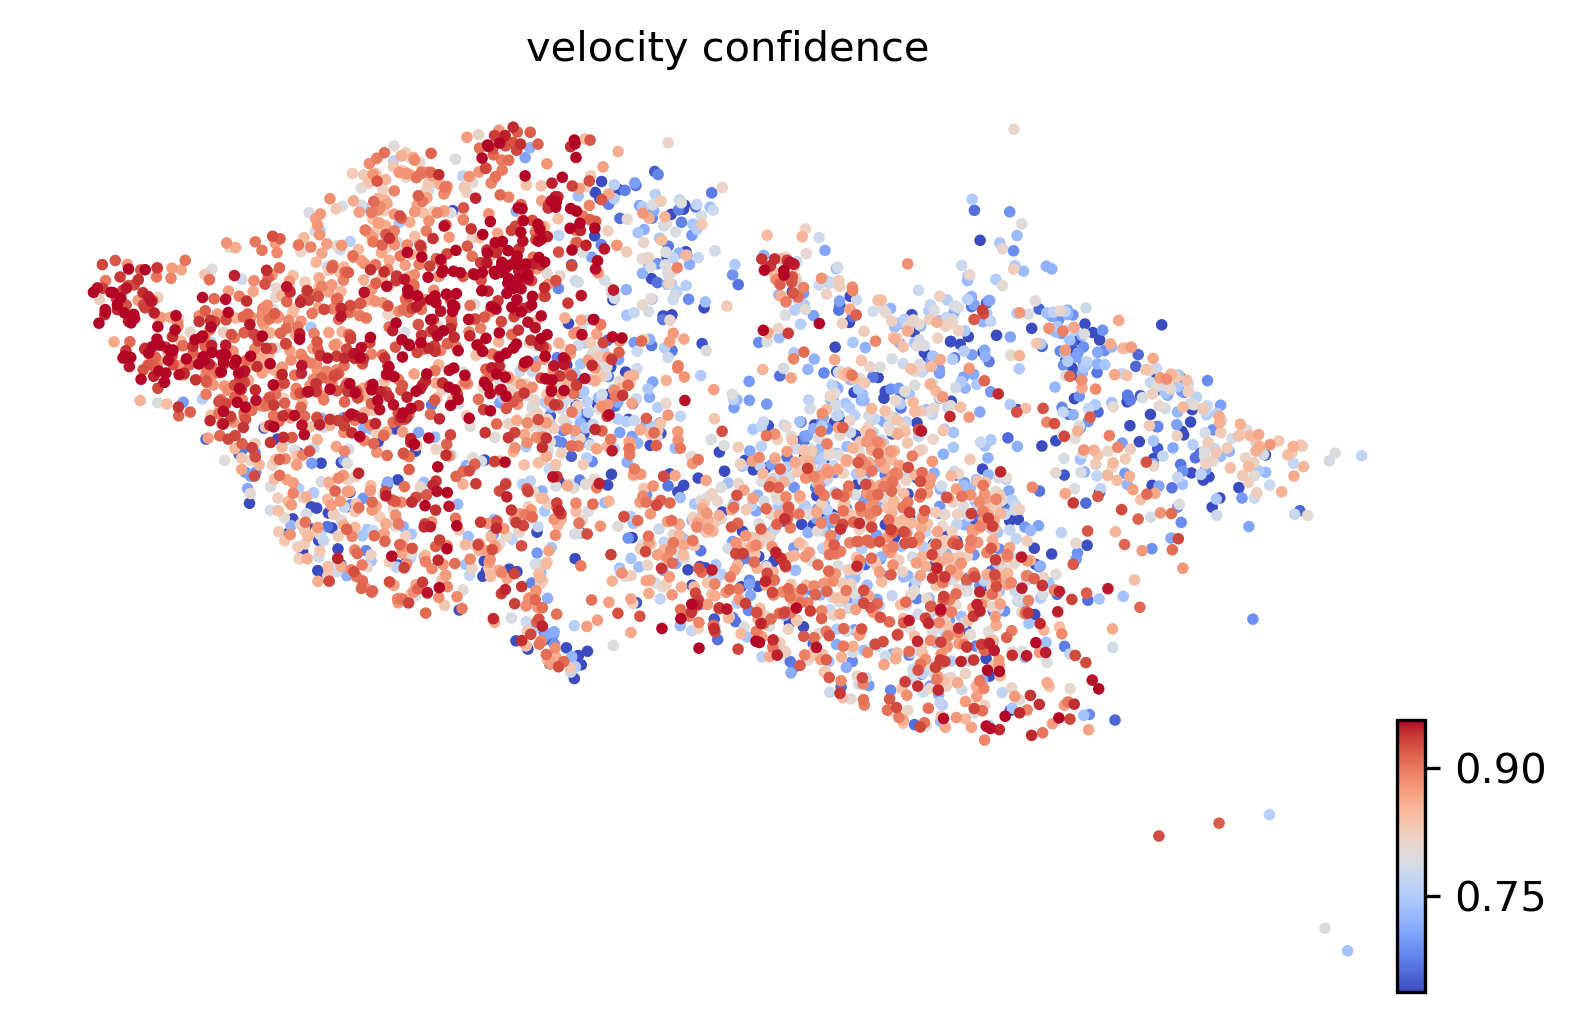

In [4]:
#####################
# Velocity analysis #
#####################

# format cluster names for plotting
velo_df.obs['clusters'] = ['cluster_' + x for x in velo_df.obs['new_clusters']]
velo_df.obs['clusters'] = velo_df.obs['clusters'].astype('category')

# create velocity graph
scv.tl.velocity(velo_df, mode="dynamical")
scv.tl.velocity_graph(velo_df)
scv.pl.velocity_embedding_stream(velo_df,
                                 color='clusters',
                                 legend_loc='none',
                                 smooth=0.8,
                                 min_mass=3,
                                 title='Myeloid Cells',
                                 dpi=300,
                                 figsize=(8, 5),
                                 legend_fontsize=12,
                                 fontsize=12,
                                 palette=["#ffbb78", "#aa40fc", "#8c564b", "#1f77b4", "#b5bd61"],
                                 show=True,
                                 save="myeloid_subset_velocity.svg"
                                 )

# plot vector coherence
scv.tl.velocity_confidence(velo_df)
scv.pl.scatter(velo_df,
               c='velocity_confidence',
               cmap='coolwarm',
               perc=[5, 95],
               dpi=300,
               show=True,
               save='myeloid_subset_coherence.pdf')

Identify terminal and initial cell states, compute cell lineage assignment probabilities, and generate a gene-shared latent time. Calculate driver genes associated with lineage probability and plot the smoothed expression of the top 100 correlated genes across latent time.

/tmp/ipykernel_68149/4043276973.py:6: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(velo_df, cluster_key='clusters', weight_connectivities=0.2)
/home/ikernin/.conda/envs/example/lib/python3.8/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/3908 [00:00<?, ?cell/s]

  0%|          | 0/3908 [00:00<?, ?cell/s]

/tmp/ipykernel_68149/4043276973.py:7: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(velo_df, cluster_key="clusters")
/home/ikernin/.conda/envs/example/lib/python3.8/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/3908 [00:00<?, ?cell/s]

  0%|          | 0/3908 [00:00<?, ?cell/s]

/tmp/ipykernel_68149/4043276973.py:8: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(velo_df)


  0%|          | 0/1 [00:00<?, ?/s]

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)
saving figure to file ./figures/scvelo_myeloid_subset_latent_time.pdf


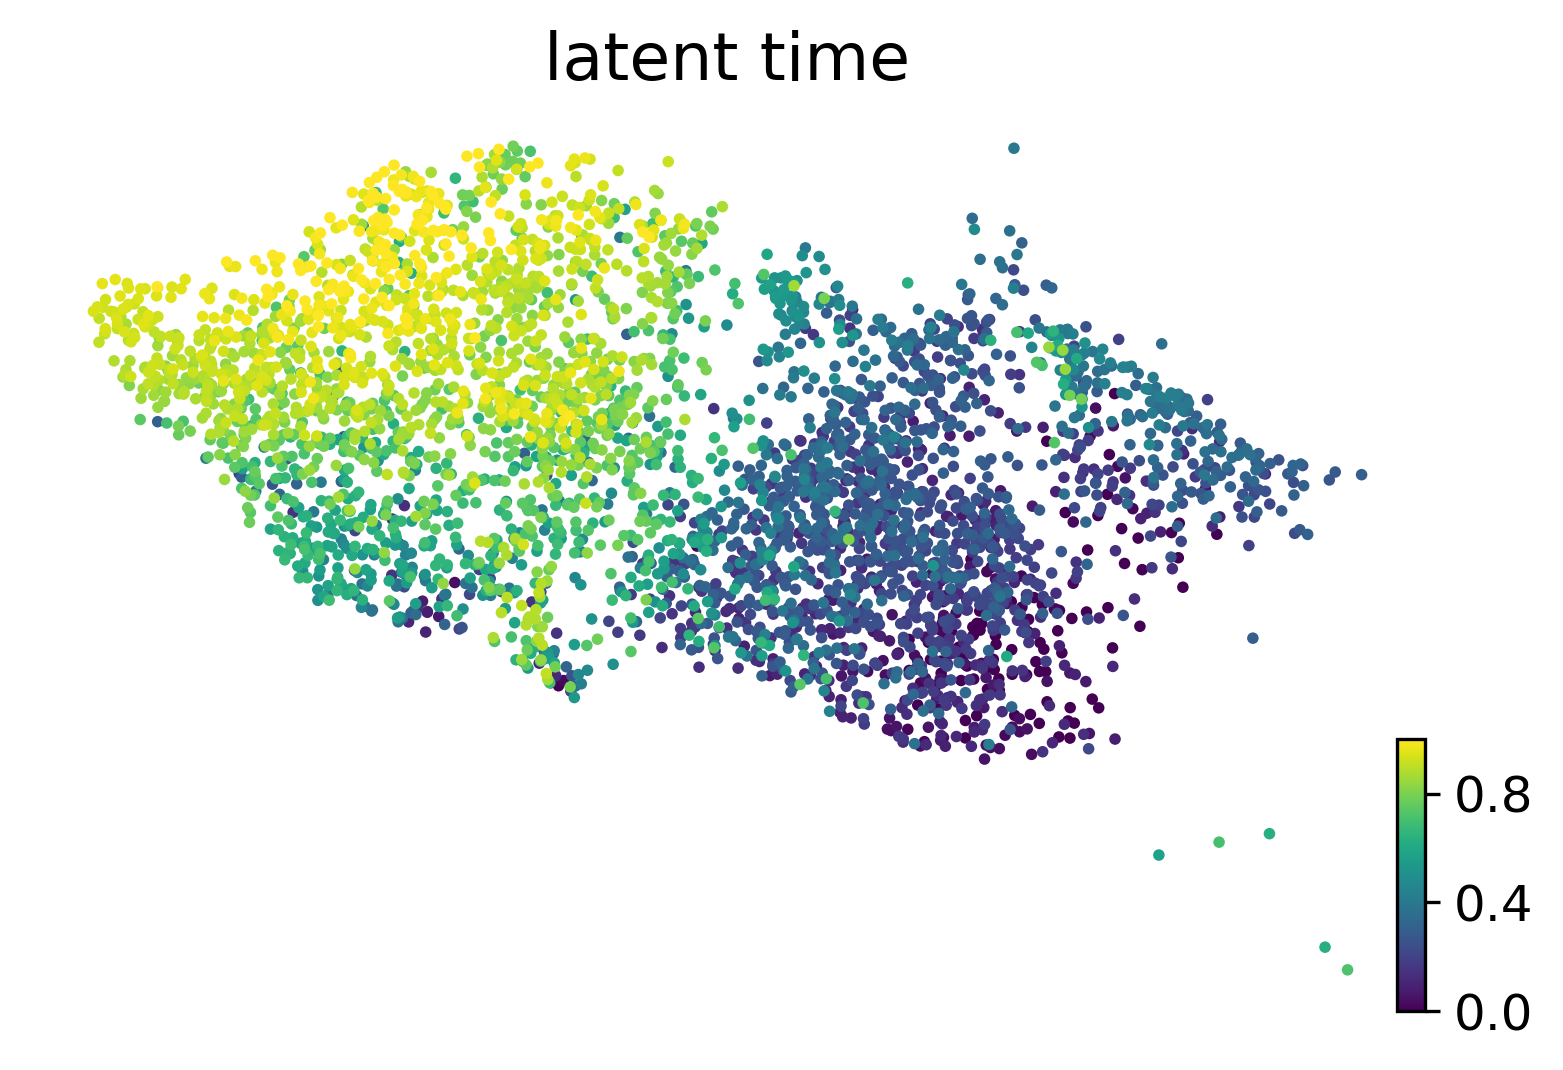

/tmp/ipykernel_68149/4043276973.py:31: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  lineage_driver_df = cr.tl.lineage_drivers(velo_df)


  0%|          | 0/100 [00:00<?, ?gene/s]

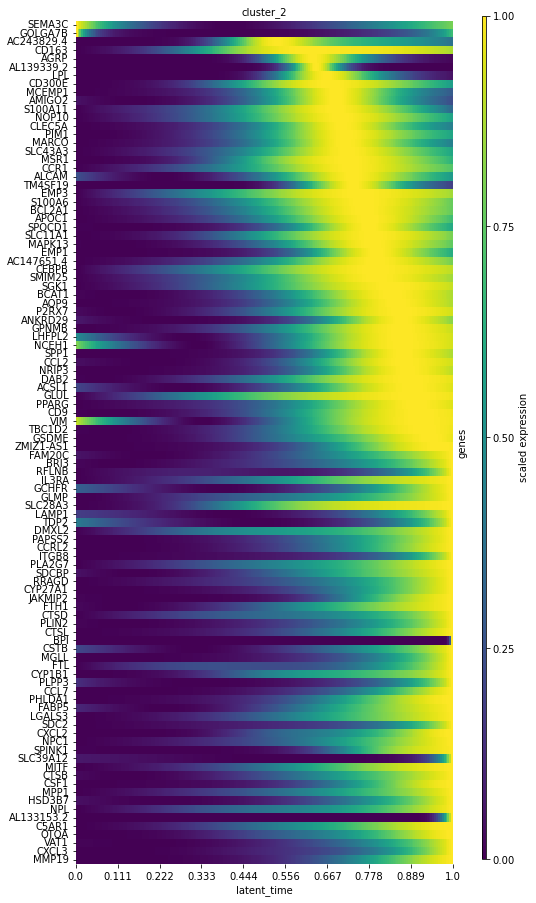

did not converge
did not converge
did not converge


In [5]:
#######################
# Trajectory analysis #
#######################

# calculate terminal and initial states and infer lineages
cr.tl.terminal_states(velo_df, cluster_key='clusters', weight_connectivities=0.2)
cr.tl.initial_states(velo_df, cluster_key="clusters")
cr.tl.lineages(velo_df)

# get latent time across dataset and plot
scv.tl.recover_latent_time(velo_df,
                           root_key="initial_states_probs",
                           end_key="terminal_states_probs")
scv.pl.scatter(
    velo_df,
    color=["latent_time"],
    fontsize=16,
    cmap="viridis",
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    ncols=1,
    legend_loc='right margin',
    title=["latent time"],
    dpi=300,
    show=True,
    save='myeloid_subset_latent_time.pdf'
)

# get lineage drivers
lineage_driver_df = cr.tl.lineage_drivers(velo_df)

# visualize lineage drivers in heatmap
model = cr.ul.models.GAM(velo_df)
lineage_drivers = cr.pl.heatmap(
    velo_df,
    model,
    genes=velo_df.varm['terminal_lineage_drivers']["cluster_2_corr"].sort_values(ascending=False).index[:100],
    show_absorption_probabilities=False,
    lineages="cluster_2",
    n_jobs=2,
    backend="loky",
    dpi=300,
    figsize=(8, 15),
    show_all_genes=True,
    save='myeloid_subset_lineage_driver_heatmap_top100.pdf'
)
lineage_drivers[0].data2d.to_csv('myeloid_subset_heatmap_data.csv')